# Preprocessing

In [0]:
import pandas as pd
import numpy as np
from glob import glob
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import os

def combine_csv():
    data_files = sorted(glob('/content/drive/My Drive/MachineLearningCSV/MachineLearningCVE/Dataset/*.pcap_ISCX.csv'))
    ids = pd.read_csv(data_files[0])
    for i in range(1, len(data_files)):
        dfi = pd.read_csv(data_files[i])
        dfi.dropna(axis=0, how='any', inplace=True)
        ids = pd.concat((ids, dfi), ignore_index=True)
    
    del dfi
    print(ids.head())
    print(ids.head())
    ids.to_csv('/content/drive/My Drive/MachineLearningCSV/MachineLearningCVE/Dataset/combined_data.csv', index=False)


def resize_dataset():
    ids = pd.read_csv('/content/drive/My Drive/MachineLearningCSV/MachineLearningCVE/Dataset/combined_data.csv',
                      dtype={'Flow Bytes/s': str, ' Flow Packets/s': str})
    labels_to_drop = {'BENIGN': 0.1, 'DoS Hulk': 0.3, 'DDoS': 0.3, 'PortScan': 0.3}
    for label in labels_to_drop:
        df = ids.loc[ids[' Label'] == label]
        ids.drop(ids.index[ids[' Label'] == label], inplace=True)
        df = df.sample(frac=labels_to_drop[label])
        ids = pd.concat((ids, df), ignore_index=True)

    ids = ids.sample(frac=1, random_state=42)
    ids.reset_index(drop=True, inplace=True)
    ids['Flow Bytes/s'] = ids['Flow Bytes/s'].str.strip()
    ids[' Flow Packets/s'] = ids[' Flow Packets/s'].str.strip()
    ids = ids.astype({'Flow Bytes/s': float, ' Flow Packets/s': float})
    ids.columns = ids.columns.str.strip()
    ids.dropna(inplace=True)
    indices_to_keep = ~ids.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    ids = ids[indices_to_keep]
    ids.to_csv('/content/drive/My Drive/MachineLearningCSV/MachineLearningCVE/Dataset/resized_data.csv', index=False)
    return ids


def binary_label_encoder(y):
    '''
    converts multiclass labels to binary labels
    '''
    y["BinaryLabel"] = (y["Label"] != 'BENIGN').astype(int)

    return y


def split_dataset(df):
    '''
    Takes a dataframe df and splits it in 0.7:0.15:0.15 ratio for training, cross-validation and test sets.
    '''
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
    for train_index, test_index in split.split(df, df['BinaryLabel']):
        train = df.loc[train_index]
        test = df.loc[test_index]

    for train_index, cv_index in split.split(train, train['BinaryLabel']):
        train = df.loc[train_index]
        cv = df.loc[cv_index]

    return train, cv, test


def main():
    if not os.path.isfile('/content/drive/My Drive/MachineLearningCSV/MachineLearningCVE/Dataset/combined_data.csv'):
        combine_csv()
    if not os.path.isfile('/content/drive/My Drive/MachineLearningCSV/MachineLearningCVE/Dataset/resized_data.csv'):
        resize_dataset()


if __name__ == "__main__":
    main()


# Feature Selection

In [0]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
#from preprocessing import binary_label_encoder, split_dataset

dataset = pd.read_csv("/content/drive/My Drive/MachineLearningCSV/MachineLearningCVE/Dataset/resized_data.csv")
dataset = binary_label_encoder(dataset)
train, cv, test = split_dataset(dataset)


y_train = train[['BinaryLabel']]
X_train = train.drop(['Label', 'BinaryLabel'], axis=1, inplace=False)
cols = X_train.columns.tolist()
mm_scaler = MinMaxScaler()
X_new = X_train
X_new[cols] = mm_scaler.fit_transform(X_train[cols])
y_train = y_train['BinaryLabel'].values

y_test = test[['BinaryLabel']]
X_test = test.drop(['Label', 'BinaryLabel'], axis=1, inplace=False)
cols = X_test.columns.tolist()
mm_scaler = MinMaxScaler()
X_new_test = X_test
X_new_test[cols] = mm_scaler.fit_transform(X_test[cols])
y_test = y_test['BinaryLabel'].values


# Features needed can be changed below to get the top 'k'
# features for model training
features_needed = 15

######################################################################

print("Selection based on Pearson Correlation")


def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:, np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X_new, y, features_needed)
print(str(len(cor_feature)), 'selected features')
print(cor_feature)

#####################################################################

print("Selection based on chi square distibution")

chi_selector = SelectKBest(chi2, k=features_needed)
X_kbest_features = chi_selector.fit_transform(X_new, y)
chi_support = chi_selector.get_support()
chi_feature = X_new.loc[:, chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)


# # More Raw Approach - Leaving the first 2 valued and
# # last NaN valued features, all other features are
# # dependent and can be considered for training

# print("Raw Approach of chi square")
# chi_scores = chi2(X_new,y)
# p_values = pd.Series(chi_scores[1],index = X_new.columns)
# p_values.sort_values(ascending = False , inplace = True)
# # p_values.plot.bar()
# # print(p_values)

Selection based on Pearson Correlation


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


15 selected features
['Flow IAT Max', 'Fwd IAT Max', 'Idle Max', 'Average Packet Size', 'Fwd IAT Std', 'Packet Length Mean', 'Packet Length Variance', 'Max Packet Length', 'Packet Length Std', 'Avg Bwd Segment Size', 'Bwd Packet Length Mean', 'Bwd Packet Length Min', 'Min Packet Length', 'Bwd Packet Length Max', 'Bwd Packet Length Std']
Selection based on chi square distibution
15 selected features
['Flow Duration', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Std', 'Fwd IAT Max', 'Packet Length Std', 'Packet Length Variance', 'PSH Flag Count', 'Avg Bwd Segment Size', 'Idle Mean', 'Idle Max', 'Idle Min']


# Model

In [0]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import sklearn
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
x1,y1 = X_new[chi_feature], y_train
x_test,y_test = X_new_test[chi_feature],y_test
#X_new.iloc[:,chi_support]  
#x2,y2 = X_new[cor_feature],y_train

In [0]:
train = torch.tensor(x1.values.astype(np.float32))
train_target = torch.tensor(y1.astype(np.float32))

train_dataset = data_utils.TensorDataset(train,train_target)
train_loader = data_utils.DataLoader(dataset= train_dataset , batch_size = 64, shuffle = True)

In [0]:
test = torch.tensor(x_test.values.astype(np.float32))
test_target = torch.tensor(y_test.astype(np.float32))

test_dataset = data_utils.TensorDataset(test,test_target)
test_loader = data_utils.DataLoader(dataset = test_dataset,batch_size =1, shuffle= False)

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(15,34)
    self.fc2 = nn.Linear(34,52)
    self.fc3 = nn.Linear(52,1)
    
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.1)
    self.batchnorm1 = nn.BatchNorm1d(34)
    self.batchnorm2 = nn.BatchNorm1d(52)

    # define forward loop
  def forward(self, inputs):
    x = self.relu(self.fc1(inputs))
    x = self.batchnorm1(x)
    x = self.relu(self.fc2(x))
    x = self.batchnorm2(x)
    x = self.dropout(x)
    x = self.fc3(x)

    return x

In [0]:
model = Net()
print(model)
Loss_function = nn.BCEWithLogitsLoss()
Optimizer_with_Regularization_Function = optim.Adam(model.parameters(),lr=0.01)

Net(
  (fc1): Linear(in_features=15, out_features=34, bias=True)
  (fc2): Linear(in_features=34, out_features=52, bias=True)
  (fc3): Linear(in_features=52, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(52, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [0]:
def binary_acc(y_pred,y_batch):
  y_pred_rounded = torch.round(torch.sigmoid(y_pred))


  correct_result_sum = (y_pred_rounded == y_batch).sum().float()
  acc = correct_result_sum / y_batch.shape[0]
  acc = torch.round(100* acc)
   
  return acc

In [0]:
model.train()
epochs = 20
for i in range(1,epochs+1):
  epochs_loss = 0
  epochs_acc = 0
  for x_batch,y_batch in train_loader:
    Optimizer_with_Regularization_Function.zero_grad()

    y_pred = model(x_batch)

    #print(y_pred.size())
    #print(y_batch.size())
    
    loss = Loss_function(y_pred,y_batch.unsqueeze(1))
    acc = binary_acc(y_pred,y_batch.unsqueeze(1))

    #backpropagation
    loss.backward()
    Optimizer_with_Regularization_Function.step() # 1 time updation
    
    epochs_loss += loss.item()
    epochs_acc += acc.item()


  print(f'Epoch {i}: | Loss: {epochs_loss/len(train_loader): .5f} | Acc: {epochs_acc/len(train_loader): .3f}')

Epoch 1: | Loss:  0.26363 | Acc:  87.574
Epoch 2: | Loss:  0.23412 | Acc:  88.549
Epoch 3: | Loss:  0.22397 | Acc:  88.988
Epoch 4: | Loss:  0.21822 | Acc:  89.432
Epoch 5: | Loss:  0.21025 | Acc:  89.902
Epoch 6: | Loss:  0.20859 | Acc:  89.992
Epoch 7: | Loss:  0.20779 | Acc:  90.001
Epoch 8: | Loss:  0.20617 | Acc:  90.088
Epoch 9: | Loss:  0.20579 | Acc:  89.959
Epoch 10: | Loss:  0.20324 | Acc:  90.279
Epoch 11: | Loss:  0.20146 | Acc:  90.324
Epoch 12: | Loss:  0.20480 | Acc:  90.101
Epoch 13: | Loss:  0.20078 | Acc:  90.055
Epoch 14: | Loss:  0.19658 | Acc:  90.350
Epoch 15: | Loss:  0.19771 | Acc:  90.244
Epoch 16: | Loss:  0.19346 | Acc:  90.585
Epoch 17: | Loss:  0.19147 | Acc:  90.764
Epoch 18: | Loss:  0.18673 | Acc:  91.018
Epoch 19: | Loss:  0.18549 | Acc:  91.061
Epoch 20: | Loss:  0.18264 | Acc:  91.195


In [0]:
model.eval()

y_pred_list = []
y_correct_list = []

with torch.no_grad():
  for x_batch,y_batch in test_loader:
    y_pred = model(x_batch)
    y_pred = torch.sigmoid(y_pred)
    y_pred_list.append(y_pred.cpu().numpy())
    y_correct_list.append(y_batch.numpy())   #numpy arrays will be formed,will convert arrays into list


y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_correct_list = [a.squeeze().tolist() for a in y_correct_list]

In [0]:
y_pred_ana = []
y_pred_non = []

len_of_list = len(y_pred_list)

for i in range(0,len_of_list):
  if y_correct_list[i] == 0:
    y_pred_non.append(y_pred_list[i])
  else:
    y_pred_ana.append(y_pred_list[i])

y_pred_non = [i*100 for i in y_pred_non]
y_pred_ana = [i*100 for i in y_pred_ana]

Text(0, 0.5, 'Occurences')

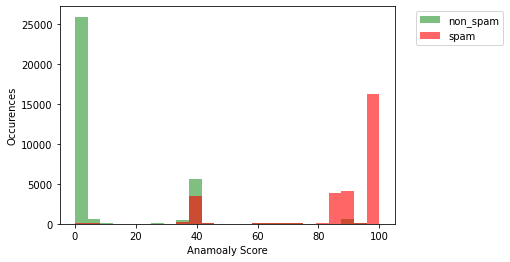

In [0]:
data = y_pred_non
bins = np.linspace(0, 100, 25, endpoint=True)
plt.hist(data,bins,color='green',alpha=0.5,label='non_spam')

data1 = y_pred_ana
plt.hist(data1,bins,color='red',alpha=0.6,label='spam')

plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.xlabel('Anamoaly Score')
plt.ylabel('Occurences')

In [0]:
from sklearn.metrics import classification_report

y_test = np.array(y_test)
y_pred_list = np.array(y_pred_list)

print(classification_report(y_test,y_pred_list.round(),target_names = ["Normal","Abnormal"]))

              precision    recall  f1-score   support

      Normal       0.89      0.97      0.93     34068
    Abnormal       0.96      0.86      0.91     29203

    accuracy                           0.92     63271
   macro avg       0.93      0.92      0.92     63271
weighted avg       0.92      0.92      0.92     63271

